In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
import pandas as pd
import numpy as np
import os
from os.path import join, isdir, dirname, basename, exists
import itertools

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(context="paper",style="white",font_scale=1.25)
from glob import glob

import matplotlib as mpl

In [3]:
# Load the data that contains shock betas for all participants
beta_df = pd.read_csv('Individual_betas_from_ROI_analysis_S.csv')

In [4]:
beta_df = beta_df[['Pair','Subject','Group','ROI','shock']]
beta_df.head()

,Pair,Subject,Group,ROI,shock
0,0,CON001,control,vmPFC,0.085120
1,0,CON001,control,PCC1,-0.556800
2,0,CON001,control,PCC2,-1.211220
3,0,CON001,control,rPAG1,0.038015
4,0,CON001,control,lPAG1,0.388202


In [5]:
eCON= '/data/bswift-1/Pessoa_Lab/eCON'
DATPAT = join(eCON,'onsetdir/{subj}/subj{subj}_run{run}.dat')
yoked = pd.read_excel(join(eCON,'onsetdir/CON_yoked_table.xlsx'))
yoked = yoked.query('use == 1').reset_index()

In [6]:
DATPAT.format(subj='001',run=0)

'/data/bswift-1/Pessoa_Lab/eCON/onsetdir/001/subj001_run0.dat'

In [7]:
# load the data from the .dat (json) file into a dictionary  
from json import load

path = DATPAT.format(subj='CON016', run=0)
with open(path, 'r') as f:
    data = load(f)

In [8]:
from pprint import pprint
pprint(data, depth=1, compact=True)

{'BlockDur': [...],
 'BlockOffset': [...],
 'BlockOnset': [...],
 'DiffProgress': [...],
 'Escapes': [...],
 'Quit': [],
 'RunDur': 455.0000139699764,
 'ShockDur': [...],
 'ShockLvl': '3.5',
 'ShockOffset': [...],
 'ShockOnset': [...],
 'nonEscapes': [...],
 'ySubj': 'CON007'}


In [9]:
df = pd.DataFrame()
for i, row in yoked.iterrows():
    subj = row['uncontrol']
    runs = np.arange(6)[row.loc['run0':'run5'].astype(bool)]
    for j, run in enumerate(runs):
        path = DATPAT.format(subj=subj, run=run)
        with open(path, 'r') as f:
            data = load(f)
            
        numEsc = len(list(itertools.chain(*data['Escapes'])))
        numNonEsc = len(data['nonEscapes'])
        tmp_df_uncon = pd.DataFrame([subj,j,numNonEsc],index=['Subject','run','buttPress']).T
        tmp_df_con = pd.DataFrame([row['control'],j,numEsc],index=['Subject','run','buttPress']).T
        df = pd.concat([df,tmp_df_con,tmp_df_uncon],axis=0,ignore_index=True)

In [10]:
beta_df.head()

,Pair,Subject,Group,ROI,shock
0,0,CON001,control,vmPFC,0.085120
1,0,CON001,control,PCC1,-0.556800
2,0,CON001,control,PCC2,-1.211220
3,0,CON001,control,rPAG1,0.038015
4,0,CON001,control,lPAG1,0.388202


In [11]:
beta_df = beta_df.groupby(['Pair','Subject','Group','ROI']).mean().unstack('ROI').reset_index()
beta_df.columns = list(beta_df.columns.get_level_values(0)[:3]) + list(beta_df.columns.get_level_values(1)[3:])

In [12]:
df = df.groupby('Subject')[['buttPress']].sum().reset_index()
df = beta_df.merge(df,left_on='Subject',right_on='Subject')
df['Pair'] = df.Pair.apply(lambda n: "P{:02d}".format(n))

In [13]:
df.head()

,Pair,Subject,Group,ACC,Amygdala_BLBM_La_L,Amygdala_BLBM_La_R,Amygdala_CeME_L,Amygdala_CeME_R,PCC1,PCC2,...,rBNST,rCa,rPAG1,rPI,rPa,rVS,rdAI,rvAI,vmPFC,buttPress
0,P00,CON001,control,0.512425,0.020962,0.064592,0.140545,0.395817,-0.556800,-1.211220,...,0.608696,0.265977,0.038015,0.304744,0.162571,0.194686,0.791671,0.652609,0.085120,120
1,P00,CON031,uncontrol,0.852019,-0.068020,0.196660,0.304366,0.627032,-0.027830,-0.820852,...,1.162880,0.396182,0.728670,1.241220,0.389171,0.255183,1.489490,0.800131,0.176639,33
2,P01,CON002,control,0.726613,0.094369,0.363922,0.416970,1.595080,0.343354,-0.314477,...,0.770967,0.279723,0.707898,0.778731,0.148607,0.166463,1.635360,0.824822,-0.031076,178
3,P01,CON021,uncontrol,0.977422,0.717683,0.499325,0.529843,1.469510,-0.015002,-0.672903,...,0.097088,0.325529,0.930600,1.082580,0.557659,0.478082,1.620790,1.103020,-0.312602,157
4,P02,CON003,control,0.601748,0.649260,-0.462635,0.220737,2.265060,0.034745,-0.060986,...,0.587932,0.300094,0.667791,1.129670,-0.137363,0.253448,1.066070,0.596786,0.196039,178


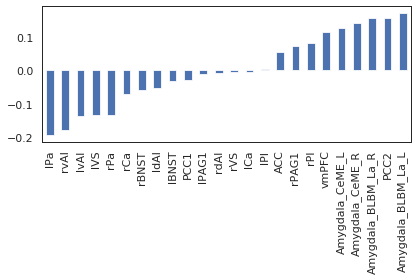

In [14]:
df.corrwith(df.buttPress,method='spearman').sort_values()[:-1].plot('bar')
plt.tight_layout()
plt.savefig('ROI_buttpress_corr.png',dpi=300)

In [15]:
beta_df['Pair'] = beta_df.Pair.apply(lambda x: 'P{:02d}'.format(x))
beta_df.head()

,Pair,Subject,Group,ACC,Amygdala_BLBM_La_L,Amygdala_BLBM_La_R,Amygdala_CeME_L,Amygdala_CeME_R,PCC1,PCC2,...,lvAI,rBNST,rCa,rPAG1,rPI,rPa,rVS,rdAI,rvAI,vmPFC
0,P00,CON001,control,0.512425,0.020962,0.064592,0.140545,0.395817,-0.556800,-1.211220,...,1.110790,0.608696,0.265977,0.038015,0.304744,0.162571,0.194686,0.791671,0.652609,0.085120
1,P00,CON031,uncontrol,0.852019,-0.068020,0.196660,0.304366,0.627032,-0.027830,-0.820852,...,0.897951,1.162880,0.396182,0.728670,1.241220,0.389171,0.255183,1.489490,0.800131,0.176639
2,P01,CON002,control,0.726613,0.094369,0.363922,0.416970,1.595080,0.343354,-0.314477,...,0.768762,0.770967,0.279723,0.707898,0.778731,0.148607,0.166463,1.635360,0.824822,-0.031076
3,P01,CON021,uncontrol,0.977422,0.717683,0.499325,0.529843,1.469510,-0.015002,-0.672903,...,0.628817,0.097088,0.325529,0.930600,1.082580,0.557659,0.478082,1.620790,1.103020,-0.312602
4,P02,CON003,control,0.601748,0.649260,-0.462635,0.220737,2.265060,0.034745,-0.060986,...,0.296808,0.587932,0.300094,0.667791,1.129670,-0.137363,0.253448,1.066070,0.596786,0.196039


In [16]:
buttonPress_df = df[['Pair','Group','buttPress']].pivot(index='Pair',columns='Group',values='buttPress')
buttonPress_df['BPdiff'] = buttonPress_df.uncontrol.subtract(buttonPress_df.control)

In [17]:
buttonPress_df.head()

Group,control,uncontrol,BPdiff
Pair,,,
P00,120,33,-87
P01,178,157,-21
P02,178,121,-57
P03,178,155,-23
P04,178,95,-83


In [18]:
buttonPress_df[buttonPress_df['uncontrol']==0]

Group,control,uncontrol,BPdiff
Pair,,,
P07,178,0,-178


In [26]:
beta_df[beta_df['Pair'] == 'P07']

,Pair,Subject,Group,ACC,Amygdala_BLBM_La_L,Amygdala_BLBM_La_R,Amygdala_CeME_L,Amygdala_CeME_R,PCC1,PCC2,...,lvAI,rBNST,rCa,rPAG1,rPI,rPa,rVS,rdAI,rvAI,vmPFC
14,P07,CON008,control,0.509657,-0.219623,-0.123485,0.366649,0.018372,0.279808,-0.282278,...,-0.007320,-0.163700,0.252144,0.575878,0.290141,0.077996,0.232358,0.336946,0.250328,0.062829
15,P07,CON053,uncontrol,0.107821,-0.271611,-0.018312,0.363088,0.107553,-0.157790,-0.318913,...,0.137861,-0.032243,-0.090120,0.421200,0.193666,0.044061,0.037022,0.248176,0.380267,-0.122965


In [23]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
buttonPress_df['BPdiff_stdz'] = ss.fit_transform(buttonPress_df[['BPdiff']])
buttonPress_df.head()

Group,control,uncontrol,BPdiff,BPdiff_stdz
Pair,,,,
P00,120,33,-87,-0.866438
P01,178,157,-21,0.373619
P02,178,121,-57,-0.302776
P03,178,155,-23,0.336041
P04,178,95,-83,-0.791283


### Add difference in button press as a covariate

In [24]:
rba_df = pd.read_csv('~/Desktop/Pessoa_Lab/eCON/dataset/data_for_RBA/uncon_v_con_shock_MR_ROI24_with_covariates.txt',delimiter = '\t',index_col='Subj')
rba_df = rba_df.join(buttonPress_df['BPdiff_stdz'])
rba_df.index.name = 'Subj'
rba_df.reset_index(inplace=True)
rba_df.to_csv('uncon_v_con_shock_MR_ROI24_with_covariates/uncon_v_con_shock_MR_ROI24_with_covariates.txt',sep='\t',index=False,float_format='%.4f')

In [43]:
rba_df.groupby('Subj')[['TRAITmean','TRAITdiff','STATEmean','STATEdiff','BPdiff_stdz']].mean().to_csv('/data/bswift-1/Pessoa_Lab/eCON/dataset/covariates.txt',sep='\t',float_format='%.4f')

In [29]:
def perm_rel_sample(samp,n_perms=10000):
    n, k, samp_dist = len(samp), 0, []
    mean_h1 = np.abs(np.mean(samp))
    for n in range(n_perms):
        mean_h0 = np.mean([val*np.random.choice([1,-1],) for val in samp])
        samp_dist.append(mean_h0)
        k += np.abs(mean_h0) > mean_h1
    return(samp_dist,(k+1)/(n_perms+1))

In [30]:
samp_dist, p_val = perm_rel_sample(buttonPress_df.uncontrol.subtract(buttonPress_df.control),10000)

In [31]:
from scipy.stats import ttest_1samp
print('Paired Samples T-test p-value: %.8f' %(ttest_1samp(buttonPress_df.uncontrol.subtract(buttonPress_df.control).values,0)[1]))
print('Paired Samples permutation test p-value: %.8f' %(p_val))

Paired Samples T-test p-value: 0.00000015
Paired Samples permutation test p-value: 0.00009999


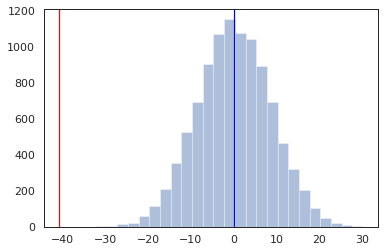

In [32]:
_=plt.hist(samp_dist,bins=25,alpha=0.45)
plt.axvline(x=np.mean(buttonPress_df.uncontrol.subtract(buttonPress_df.control).values),c='red',label='Observed mean')
plt.axvline(x=np.mean(samp_dist),c='blue',label='Mean of \nsampling dsitribution')

Text(0.5, 0, 'Number of button press: (uncontrol-control)')

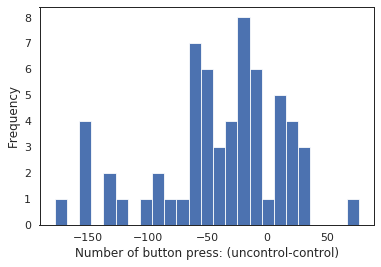

In [33]:
(buttonPress_df.uncontrol - buttonPress_df.control).plot(kind='hist',bins=25)
plt.xlabel('Number of button press: (uncontrol-control)')

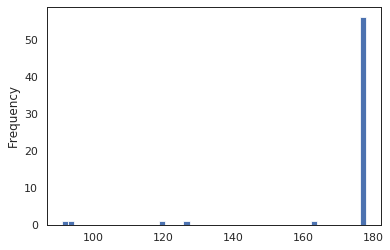

In [39]:
buttonPress_df.control.plot('hist',bins=50)

In [42]:
buttonPress_df.control[buttonPress_df.control == 178].shape

(56,)

In [57]:
con_df = pd.DataFrame(columns=['Subject','run','trial','buttPress'])
for i, row in yoked.iterrows():
    subj = row['uncontrol']
    runs = np.arange(6)[row.loc['run0':'run5'].astype(bool)]
    for j, run in enumerate(runs,start=1):
        path = DATPAT.format(subj=subj, run=run)
        with open(path, 'r') as f:
            data = load(f)
        
        for k,event in enumerate(data['Escapes'],start=1):
            tmp_df = pd.DataFrame([data['ySubj'],j,k,len(event)],index=['Subject','run','trial','buttPress']).T
            con_df = con_df.append(tmp_df,ignore_index=True)
            
con_df['buttPress'] = con_df['buttPress'].astype(float)

Text(0.5, 0, '(Run, Trial)')

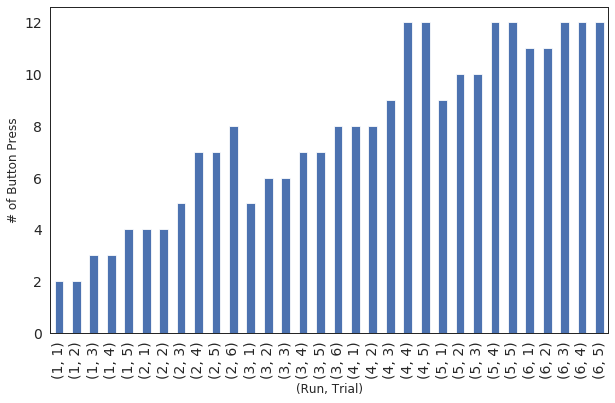

In [59]:
con_df.groupby(['run','trial'])['buttPress'].mean().round().plot('bar',figsize=(10,6),fontsize=14)
plt.ylabel('# of Button Press')
plt.xlabel('(Run, Trial)')